In [319]:
# setup e test librerie
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Importare i dati

In [320]:
mushrooms = pd.read_csv("mushrooms_cleaned.csv")

y = mushrooms["is-edible"]
X_all = mushrooms.drop(columns="is-edible")

Select KBest features and only use those

In [321]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest()
best_features = selector.fit_transform(X_all, y)

X = pd.DataFrame(best_features, columns=selector.get_feature_names_out())

Splitting data

In [322]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=1/3,
    random_state=42
)

Creating function for printing an evaluation

In [323]:
def print_eval(X, y, model):
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy/Score: {accuracy:.5}")

    print("Classification report")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

Creating function for printing the coefficients of the features

In [324]:
def print_coefficients(classifier):
    print("Coefficients")
    for i in range(len(X.columns)):
        print(f"{X.columns[i]}: {classifier.coef_[0][i]}")

Try and evaluate logistic regression

Accuracy/Score: 0.77464
Classification report
              precision    recall  f1-score   support

       False       0.81      0.84      0.83      3933
        True       0.70      0.65      0.67      2186

    accuracy                           0.77      6119
   macro avg       0.76      0.75      0.75      6119
weighted avg       0.77      0.77      0.77      6119



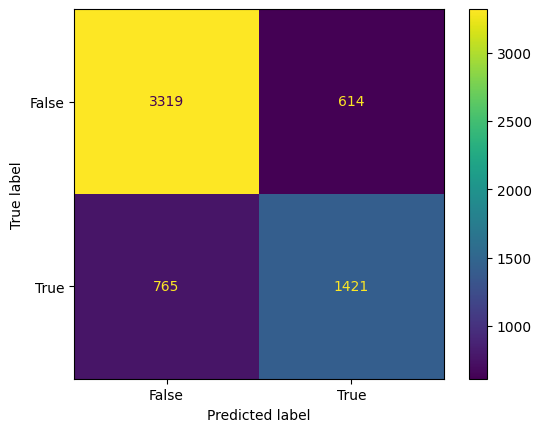

In [325]:
from sklearn.linear_model import LogisticRegression

logreg_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver="saga"))
])
logreg_model.fit(X_train, y_train)

# print_coefficients(logreg_model.named_steps["lr"])
print_eval(X_val, y_val, logreg_model)

Try and evaluate decision tree

Accuracy/Score: 0.77153
Classification report
              precision    recall  f1-score   support

       False       0.86      0.77      0.81      3933
        True       0.65      0.77      0.71      2186

    accuracy                           0.77      6119
   macro avg       0.76      0.77      0.76      6119
weighted avg       0.78      0.77      0.77      6119



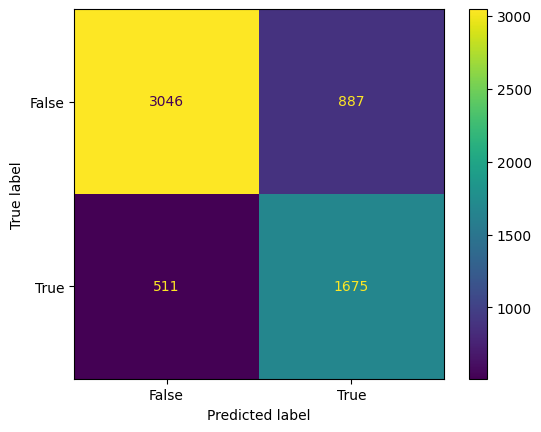

In [326]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

tree_model = Pipeline([
    ("scaler", StandardScaler()),
    ("dtc", DecisionTreeClassifier(max_depth=3))
])
tree_model.fit(X_train, y_train)

# plot_tree(tree_model.named_steps["dtc"])
print_eval(X_val, y_val, tree_model)

Try and evaluate ridge

Accuracy/Score: 0.77153
Classification report
              precision    recall  f1-score   support

       False       0.82      0.83      0.82      3933
        True       0.69      0.66      0.67      2186

    accuracy                           0.77      6119
   macro avg       0.75      0.75      0.75      6119
weighted avg       0.77      0.77      0.77      6119



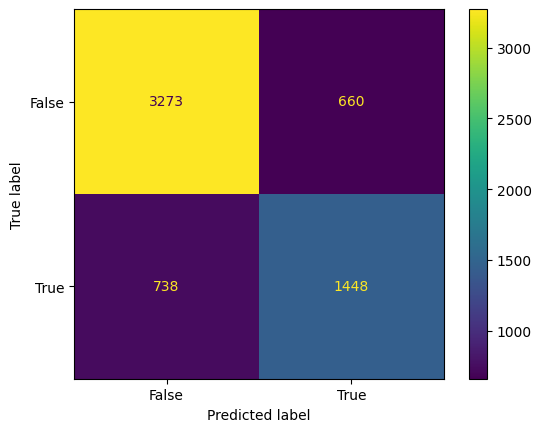

In [327]:
from sklearn.linear_model import RidgeClassifier

ridge_model = Pipeline([
    ("scaler", StandardScaler()),
    ("rc", RidgeClassifier(alpha=0.5))
])
ridge_model.fit(X_train, y_train)

# print_coefficients(ridge_model.named_steps["rc"])
print_eval(X_val, y_val, ridge_model)

Try and evaluate Random forest

Accuracy/Score: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3933
        True       1.00      1.00      1.00      2186

    accuracy                           1.00      6119
   macro avg       1.00      1.00      1.00      6119
weighted avg       1.00      1.00      1.00      6119



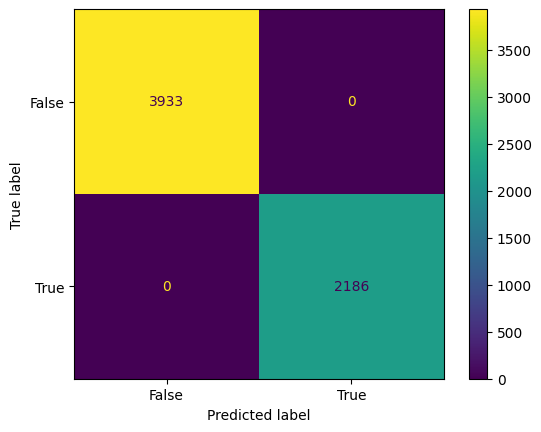

In [328]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = Pipeline([
    ("scaler", StandardScaler()),
    ("rfc", RandomForestClassifier())
])
random_forest_model.fit(X_train, y_train)

print_eval(X_val, y_val, random_forest_model)

Try and evaluate svm

Accuracy/Score: 0.99967
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3933
        True       1.00      1.00      1.00      2186

    accuracy                           1.00      6119
   macro avg       1.00      1.00      1.00      6119
weighted avg       1.00      1.00      1.00      6119



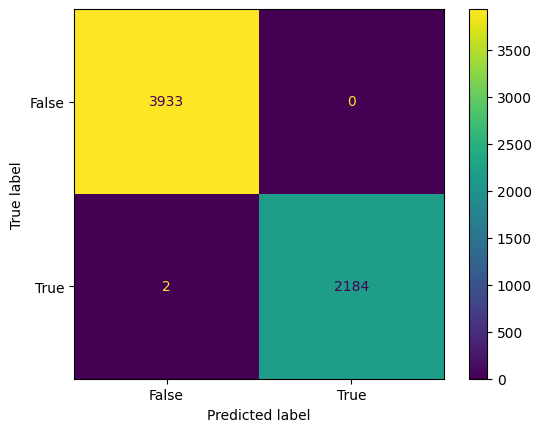

In [342]:
from sklearn.svm import SVC

svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, random_state=42))
])
svm_model.fit(X_train, y_train)

print_eval(X_val, y_val, svm_model)

KNN classifier

Accuracy/Score: 1.0
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3933
        True       1.00      1.00      1.00      2186

    accuracy                           1.00      6119
   macro avg       1.00      1.00      1.00      6119
weighted avg       1.00      1.00      1.00      6119



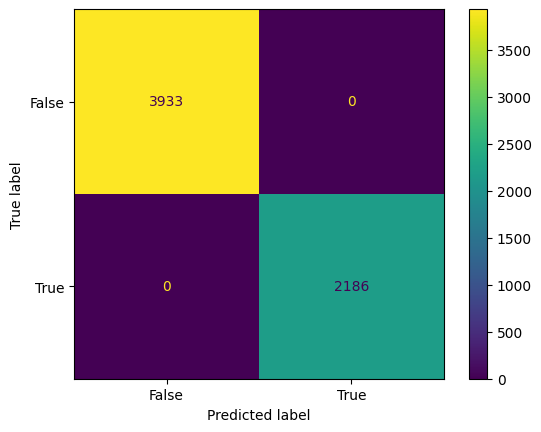

In [330]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])
knn_model.fit(X_train, y_train)

print_eval(X_val, y_val, knn_model)

Dummy classifier comparison

Accuracy/Score: 0.64275
Classification report
              precision    recall  f1-score   support

       False       0.64      1.00      0.78      3933
        True       0.00      0.00      0.00      2186

    accuracy                           0.64      6119
   macro avg       0.32      0.50      0.39      6119
weighted avg       0.41      0.64      0.50      6119



/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

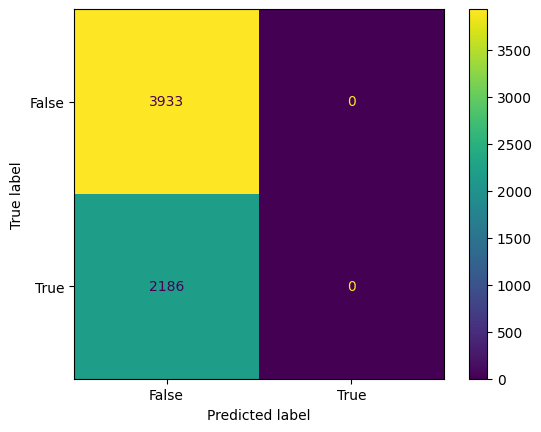

In [331]:
from sklearn.dummy import DummyClassifier

dummy_model = Pipeline([
    ("scaler", StandardScaler()),
    ("dc", DummyClassifier(random_state=42))
])
dummy_model.fit(X_train, y_train)

print_eval(X_val, y_val, dummy_model)

/Users/mauropellonara/Documents/mushrooms-classification/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


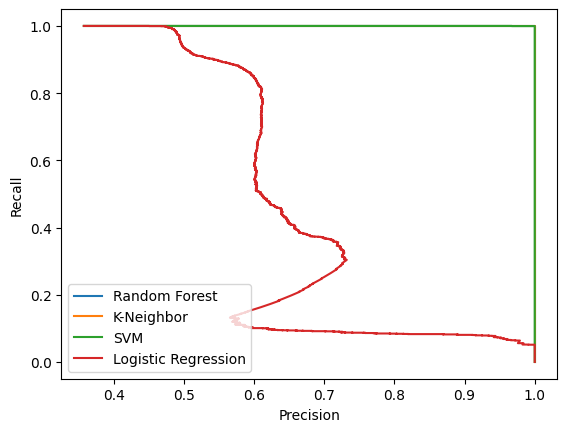

In [349]:
from sklearn.metrics import precision_recall_curve

precision_rf, recall_rf, _ = precision_recall_curve(y_val, random_forest_model.predict_proba(X_val)[:, 1])
precision_knn, recall_knn, _ = precision_recall_curve(y_val, knn_model.predict_proba(X_val)[:, 1])
precision_svm, recall_svm, _ = precision_recall_curve(y_val, svm_model.predict_proba(X_val)[:, 1])
precision_logreg, recall_logreg, _ = precision_recall_curve(y_val, logreg_model.named_steps["lr"].predict_proba(X_val)[:, 1])

plt.plot(precision_rf, recall_rf, label="Random Forest")
plt.plot(precision_knn, recall_knn, label="K-Neighbor")
plt.plot(precision_svm, recall_svm, label="SVM")
plt.plot(precision_logreg, recall_logreg, label="Logistic Regression")

plt.xlabel("Precision")
plt.ylabel("Recall")

plt.legend(loc="lower left")